# AT&T Spam Detector - BLOC 5
## PART 3 : DistilBERT model with Tensorflow
Developed by Myriam Goyet     
Contact : https://www.linkedin.com/in/myriamgoyet/

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import random
import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score,confusion_matrix
from transformers import AutoTokenizer
from sklearn.utils.class_weight import compute_class_weight 
import os
import json
from tensorflow.keras.callbacks import EarlyStopping
import collections






# 1. Load data and model

In [2]:
df3 = pd.read_csv('AT&T_data_preprocessed.csv')
# Replace missing values with an empty string and convert everything to strings
df3['clean_data'] = df3['clean_data'].fillna('').astype(str)

For this second try, we will fine-tune a BERT model:
BERT (Bidirectional Encoder Representations from Transformers) is a model designed for understanding human language and is abble to grasp the context of words based on their surroundings.

Here, we will use **distilbert-base-uncased**, a smaller, faster version of the BERT language model. It retains most of BERT's capabilities while being more efficient. Created using a process called distillation, it learns from BERT but requires less computational power, making it ideal for environments with limited resources. Despite its reduced size, DistilBERT performs nearly as well as BERT in understanding and processing language tasks.

In [4]:
# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

# 2. Train model 

In [8]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# train_test_split 
xtrain, xval, ytrain, yval = train_test_split(
    df3, df3["target"], stratify=df3["target"], test_size=0.3, random_state=seed
)


train_texts = xtrain["clean_data"].tolist()
val_texts = xval["clean_data"].tolist()
train_labels = ytrain.tolist()
val_labels = yval.tolist()

# 2. Tokenization
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=130)
val_enc = tokenizer(val_texts, truncation=True, padding=True, max_length=130)

def to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": tf.constant(encodings["input_ids"]),
            "attention_mask": tf.constant(encodings["attention_mask"]),
        },
        tf.constant(labels)
    ))

train_dataset = to_tf_dataset(train_enc, train_labels).shuffle(1000, seed=seed).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = to_tf_dataset(val_enc, val_labels).batch(32).prefetch(tf.data.AUTOTUNE)

# 3. Compute class weights
computed_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: float(w) for i, w in enumerate(computed_weights)}
print("Class weights:", class_weights)

# 4. Model
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

# Unfreeze last 4 layers
for layer in model.distilbert.transformer.layer[:-4]:
    layer.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1)
]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Class weights: {0: 0.5722872508699779, 1: 3.9584245076586435}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

In [5]:
# 5. Train with class weights

# Record the start time
start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks,
    class_weight=class_weights
)

# Record the end time
end_time = time.time()

# Calculate the duration
training_duration = end_time - start_time
print(f"Training took {training_duration:.2f} seconds ({training_duration / 60:.2f} minutes)")



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Class weights: {0: 0.5722872508699779, 1: 3.9584245076586435}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

Epoch 1/5


2025-07-08 19:39:14.290499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [3618,130]
	 [[{{node Placeholder/_1}}]]
2025-07-08 19:39:14.292915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype float and shape [2]
	 [[{{node Placeholder/_14}}]]


114/114 [==============================] - ETA: 0s - loss: 0.1800 - binary_accuracy: 0.9696

2025-07-08 19:47:37.693517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1551]
	 [[{{node Placeholder/_2}}]]


114/114 [==============================] - 561s 5s/step - loss: 0.1800 - binary_accuracy: 0.9696 - val_loss: 0.0721 - val_binary_accuracy: 0.9845 - lr: 5.0000e-05
Epoch 2/5
114/114 [==============================] - 527s 5s/step - loss: 0.0517 - binary_accuracy: 0.9914 - val_loss: 0.1299 - val_binary_accuracy: 0.9742 - lr: 5.0000e-05
Epoch 3/5
114/114 [==============================] - 539s 5s/step - loss: 0.0201 - binary_accuracy: 0.9950 - val_loss: 0.0439 - val_binary_accuracy: 0.9884 - lr: 2.5000e-05
Epoch 4/5
114/114 [==============================] - 541s 5s/step - loss: 0.0049 - binary_accuracy: 0.9994 - val_loss: 0.0527 - val_binary_accuracy: 0.9877 - lr: 2.5000e-05
Epoch 5/5
114/114 [==============================] - 521s 5s/step - loss: 0.0019 - binary_accuracy: 1.0000 - val_loss: 0.0511 - val_binary_accuracy: 0.9884 - lr: 1.2500e-05
Training took 2688.54 seconds (44.81 minutes)


In [6]:
# Save model to Hugging Face-compatible directory
def save_model_and_tokenizer(model, tokenizer, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"✅ Model and tokenizer saved to: {save_dir}")

In [7]:
save_model_and_tokenizer(model, tokenizer, save_dir="Models_trained/DistilBERT_ft")

✅ Model and tokenizer saved to: Models_trained/DistilBERT_ft


# 3. Evaluate Model and save metrics

In [8]:
def evaluate_model(model, train_dataset, val_dataset, model_name="model", output_dir="Evaluations"):
    # 1. Make predictions
    y_pred_train_logits = model.predict(train_dataset).logits
    y_pred_val_logits = model.predict(val_dataset).logits

    # Convert logits to probabilities (sigmoid) and then to binary predictions
    y_pred_train = (tf.sigmoid(y_pred_train_logits).numpy().flatten() > 0.5).astype(int)
    y_pred_val = (tf.sigmoid(y_pred_val_logits).numpy().flatten() > 0.5).astype(int)

    # 2. Extract ground-truth labels from datasets
    y_true_train = np.concatenate([y.numpy() for _, y in train_dataset])
    y_true_val = np.concatenate([y.numpy() for _, y in val_dataset])

    # 3. Classification report
    report_train = classification_report(y_true_train, y_pred_train, output_dict=True)
    report_val = classification_report(y_true_val, y_pred_val, output_dict=True)

    print("📊 Classification Report — Train")
    print(classification_report(y_true_train, y_pred_train))
    print("\n📊 Classification Report — Validation")
    print(classification_report(y_true_val, y_pred_val))

    # 4. Confusion matrices
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_val = confusion_matrix(y_true_val, y_pred_val)

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - Train ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - Validation ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 5. Summary metrics
    summary_train = {
        "accuracy": accuracy_score(y_true_train, y_pred_train),
        "precision": report_train["weighted avg"]["precision"],
        "recall": report_train["weighted avg"]["recall"],
        "f1-score": report_train["weighted avg"]["f1-score"]
    }

    summary_val = {
        "accuracy": accuracy_score(y_true_val, y_pred_val),
        "precision": report_val["weighted avg"]["precision"],
        "recall": report_val["weighted avg"]["recall"],
        "f1-score": report_val["weighted avg"]["f1-score"]
    }

    # 6. Save all metrics
    os.makedirs(output_dir, exist_ok=True)
    metrics = {
        "model_name": model_name,
        "train_metrics": report_train,
        "val_metrics": report_val,
        "train_summary": summary_train,
        "val_summary": summary_val
    }
    json_path = os.path.join(output_dir, f"{model_name}_metrics.json")
    with open(json_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Metrics saved to {json_path}")



2025-07-08 20:24:03.289329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [3618,130]
	 [[{{node Placeholder/_0}}]]
2025-07-08 20:24:03.289605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [3618,130]
	 [[{{node Placeholder/_0}}]]


 19/114 [====>.........................] - ETA: 2:01

49/49 [==============================] - 68s 1s/step
📊 Classification Report — Train
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3161
           1       0.11      0.11      0.11       457

    accuracy                           0.78      3618
   macro avg       0.49      0.49      0.49      3618
weighted avg       0.78      0.78      0.78      3618


📊 Classification Report — Validation
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1355
           1       0.94      0.95      0.95       196

    accuracy                           0.99      1551
   macro avg       0.97      0.97      0.97      1551
weighted avg       0.99      0.99      0.99      1551



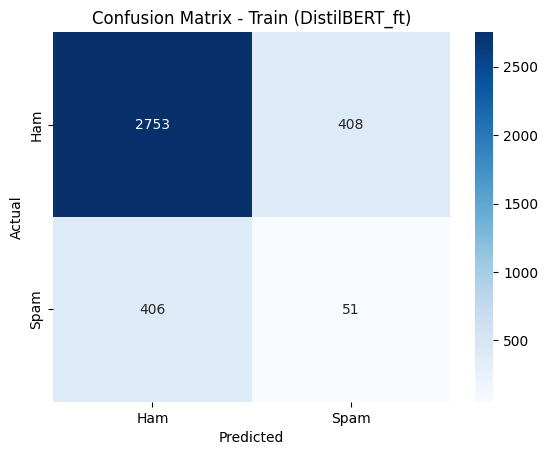

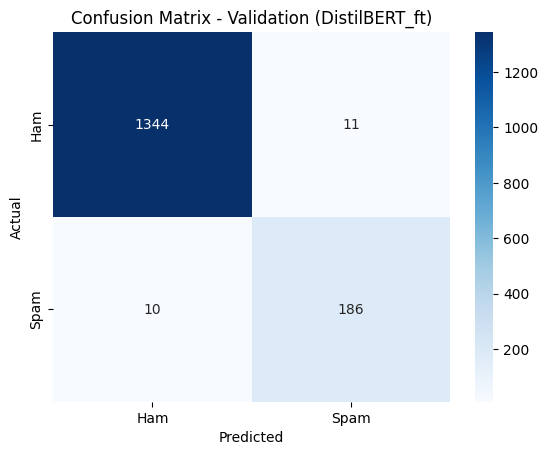

✅ Metrics saved to Evaluations/DistilBERT_ft_metrics.json


In [9]:
evaluate_model(model, train_dataset, val_dataset, model_name="DistilBERT_ft")

Our model is not good at identifying Spams (recall at 0.11 in train set)...   

# 4. Optimisation of the threshold

In [10]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize function
def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=130)

# TensorFlow dataset conversion
def to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": tf.constant(encodings["input_ids"]),
            "attention_mask": tf.constant(encodings["attention_mask"]),
        },
        tf.constant(labels)
    )).batch(32)

# K-Fold Threshold Optimization
def optimize_thresholds_kfold(df, tokenizer, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    thresholds_all = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df["clean_data"], df["target"])):
        print(f"\n🔁 Fold {fold + 1}")
        xtrain, xval = df.iloc[train_idx], df.iloc[val_idx]
        ytrain, yval = xtrain["target"].tolist(), xval["target"].tolist()

        # Tokenization
        train_enc = tokenize_texts(xtrain["clean_data"].tolist())
        val_enc = tokenize_texts(xval["clean_data"].tolist())

        # TF Datasets
        train_dataset = to_tf_dataset(train_enc, ytrain)
        val_dataset = to_tf_dataset(val_enc, yval)

        # Model
        model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )

        # Training (short for speed)
        model.fit(train_dataset, epochs=3, callbacks=[
            EarlyStopping(monitor="loss", patience=1, restore_best_weights=True)
        ], verbose=0)

        # Predictions
        probs = tf.sigmoid(model.predict(val_dataset).logits).numpy().flatten()

        # Threshold search
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1, best_t = 0, 0.5

        for t in thresholds:
            preds = (probs >= t).astype(int)
            f1 = f1_score(yval, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t

        print(f"✅ Fold {fold+1} best threshold: {best_t} (F1: {best_f1:.4f})")
        thresholds_all.append((best_t, best_f1))

    # Moyenne simple
    raw_thresholds = [t for t, _ in thresholds_all]
    mean_threshold = np.mean(raw_thresholds)

    # Moyenne pondérée par F1
    weighted_threshold = np.average(
        [t for t, _ in thresholds_all], weights=[f for _, f in thresholds_all]
    )

    print(f"\n📊 Threshold for each fold: {raw_thresholds}")
    print(f"🔧 Mean Threshold : {mean_threshold:.4f}")
    print(f"🏋️ Weighted Threshold (F1): {weighted_threshold:.4f}")

    return raw_thresholds, mean_threshold, weighted_threshold


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
raw_thresholds, mean_threshold, weighted_threshold = optimize_thresholds_kfold(df3, tokenizer, n_splits=5)

print("📋 Threshold for each fold:", raw_thresholds)
print("🔧 Mean Threshold :", round(mean_threshold, 4))
print("🏋️ Weighted Threshold (F1):", round(weighted_threshold, 4))



🔁 Fold 1


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

33/33 [==============================] - 39s 1s/step
✅ Fold 1 best threshold: 0.1 (F1: 0.9520)

🔁 Fold 2


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

33/33 [==============================] - 41s 1s/step
✅ Fold 2 best threshold: 0.1 (F1: 0.9885)

🔁 Fold 3


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

33/33 [==============================] - 30s 883ms/step
✅ Fold 3 best threshold: 0.1 (F1: 0.9615)

🔁 Fold 4


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

33/33 [==============================] - 51s 2s/step
✅ Fold 4 best threshold: 0.30000000000000004 (F1: 0.9535)

🔁 Fold 5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassific

33/33 [==============================] - 53s 2s/step
✅ Fold 5 best threshold: 0.5500000000000002 (F1: 0.9695)

📊 Threshold for each fold: [0.1, 0.1, 0.1, 0.30000000000000004, 0.5500000000000002]
🔧 Mean Threshold : 0.2300
🏋️ Weighted Threshold (F1): 0.2299
📋 Threshold for each fold: [0.1, 0.1, 0.1, 0.30000000000000004, 0.5500000000000002]
🔧 Mean Threshold : 0.23
🏋️ Weighted Threshold (F1): 0.2299


In [12]:
# Save optimized threshold
save_path = "Models_trained/DistilBERT_ft"
os.makedirs(save_path, exist_ok=True)

# Save threshold
threshold = round(weighted_threshold, 4)
with open(os.path.join(save_path, "DistilBERT_ft_threshold.json"), "w") as f:
    json.dump({"threshold": threshold}, f)

print("✅ Threshold saved in :", os.path.join(save_path, "DistilBERT_ft_threshold.json"))

✅ Threshold saved in : Models_trained/DistilBERT_ft/DistilBERT_ft_threshold.json


# 5. Evaluate model with new threshold

In [13]:
# Path to the directory where you saved the model/tokenizer
save_dir = "Models_trained/DistilBERT_ft"

tokenizer = DistilBertTokenizer.from_pretrained(save_dir)
model = TFDistilBertForSequenceClassification.from_pretrained(save_dir)

# Path to the threshold file
threshold_path = "Models_trained/DistilBERT_ft/DistilBERT_ft_threshold.json"
# Load the threshold
with open(threshold_path, "r") as f:
    data = json.load(f)
    weighted_threshold = data["threshold"]


Some layers from the model checkpoint at Models_trained/DistilBERT_ft were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Models_trained/DistilBERT_ft and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def evaluate_model_threshold(model, train_dataset, val_dataset, model_name="model", output_dir="Evaluations", threshold=0.5):
    # 1. Make predictions
    y_pred_train_logits = model.predict(train_dataset).logits
    y_pred_val_logits = model.predict(val_dataset).logits

    # Convert logits to probabilities and apply threshold
    y_pred_train = (tf.sigmoid(y_pred_train_logits).numpy().flatten() > threshold).astype(int)
    y_pred_val = (tf.sigmoid(y_pred_val_logits).numpy().flatten() > threshold).astype(int)

    # 2. Extract true labels
    y_true_train = np.concatenate([y.numpy() for _, y in train_dataset])
    y_true_val = np.concatenate([y.numpy() for _, y in val_dataset])

    # 3. Classification reports
    report_train = classification_report(y_true_train, y_pred_train, output_dict=True)
    report_val = classification_report(y_true_val, y_pred_val, output_dict=True)

    print(f"📊 Classification Report — Train (threshold={threshold})")
    print(classification_report(y_true_train, y_pred_train))
    print(f"\n📊 Classification Report — Validation (threshold={threshold})")
    print(classification_report(y_true_val, y_pred_val))

    # 4. Confusion matrices (heatmaps)
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_val = confusion_matrix(y_true_val, y_pred_val)

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - Train ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - Validation ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 5. Summary metrics
    summary_train = {
        "accuracy": accuracy_score(y_true_train, y_pred_train),
        "precision": report_train["weighted avg"]["precision"],
        "recall": report_train["weighted avg"]["recall"],
        "f1-score": report_train["weighted avg"]["f1-score"]
    }

    summary_val = {
        "accuracy": accuracy_score(y_true_val, y_pred_val),
        "precision": report_val["weighted avg"]["precision"],
        "recall": report_val["weighted avg"]["recall"],
        "f1-score": report_val["weighted avg"]["f1-score"]
    }

    # 6. Save metrics in JSON
    os.makedirs(output_dir, exist_ok=True)
    metrics = {
        "model_name": model_name,
        "threshold": threshold,
        "train_metrics": report_train,
        "val_metrics": report_val,
        "train_summary": summary_train,
        "val_summary": summary_val
    }
    json_path = os.path.join(output_dir, f"{model_name}_metrics.json")
    with open(json_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"✅ Metrics saved to {json_path}")


2025-07-09 00:31:55.748154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [3618]
	 [[{{node Placeholder/_2}}]]
2025-07-09 00:31:55.749454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [3618,130]
	 [[{{node Placeholder/_1}}]]


114/114 [==============================] - 154s 1s/step


2025-07-09 00:34:29.841807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1551]
	 [[{{node Placeholder/_2}}]]


49/49 [==============================] - 64s 1s/step
📊 Classification Report — Train (threshold=0.2299)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3161
           1       0.10      0.11      0.10       457

    accuracy                           0.77      3618
   macro avg       0.49      0.49      0.49      3618
weighted avg       0.77      0.77      0.77      3618


📊 Classification Report — Validation (threshold=0.2299)
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1355
           1       0.89      0.96      0.93       196

    accuracy                           0.98      1551
   macro avg       0.94      0.97      0.96      1551
weighted avg       0.98      0.98      0.98      1551



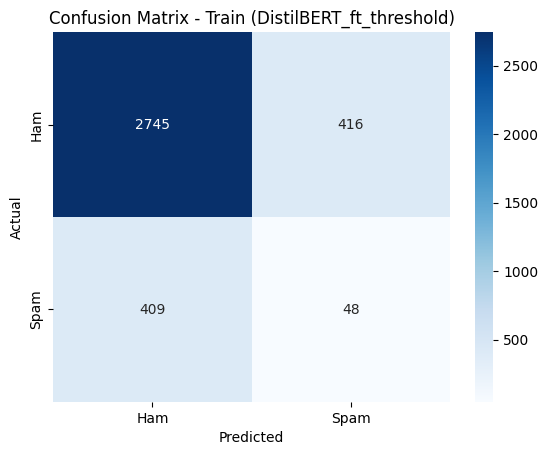

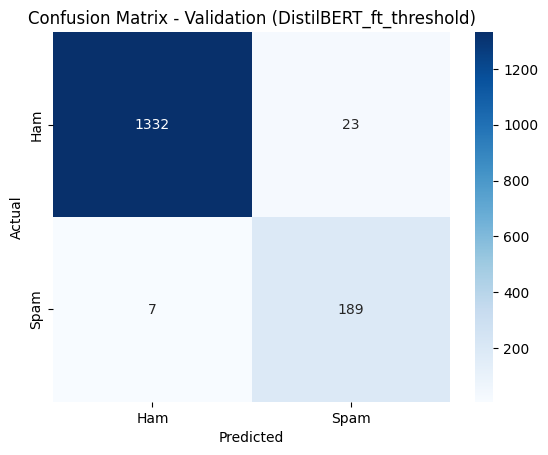

✅ Metrics saved to Evaluations/DistilBERT_ft_threshold_metrics.json


In [15]:
evaluate_model_threshold(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_name="DistilBERT_ft_threshold",
    output_dir="Evaluations",
    threshold=weighted_threshold
)


Our model is still not good...